# Named Entity Recognition with Flair for CLS

This Notebook shows you how to perform NER and/or aspect recognition on your data using the NLP-library [Flair](https://flairnlp.github.io/). This Notebook gives you a general overview of how to perform NER with the Natural Language Processing framework Flair for literary-historical texts in **English**, **French**, **German** and **Dutch** in different scenarios:

1.   **You do not have any labelled data to train your own NER-system, and the entities you want to recognize are part of the spaCy models.
Generic NER through Flair for French, Dutch, German and English.**

    *   Apply generic entity recognition using Flair's off-the-shelf models for English, Dutch, French and German.


2.   **You do not have any labelled data to train your own NER-system, but you do want to recognize domain-specific entities which are not part of the Flair's models.**

    * Apply NER/aspect recognition using Flair's off-the-shelf [zero-shot model TARS](https://aclanthology.org/2020.coling-main.285/).  


3.   **You have enough annotations available to 1) use the TARSTagger for few-shot learning OR 2) train your own TARSTagger or SequenceTagger from scratch to recognize domain-specific entities.**
     *   Train a TarsTagger for few-shot learning.
     *   Train a TarsTagger from scratch with adequate embeddings from HuggingFace.
     *   Evaluate the performance on a held-out test set.








## Input and output


The notebook starts with **.txt-files** as input, and outputs a **.csv-file** in the following structure:

Text_name | Entity_text | Entity_sentence | Entity_category
-------------|------------|------------|------------
file.txt      |Rome| All roads lead to Rome. | LOCATION


---

📜🎓 **Side-note for the commmon good**

Are these methods all-encompassing? **No**.

Do we need to be full-fledged NLP-engineers to apply information extraction? **Not really**.

Do we need to know the pitfalls of applying these methods to our texts? **Big yes**.

Is the NLP-landscape currently changing at hyperspeed and may this Notebook be outdated when I read it? **Humongous yes**.

❗ So take this notebook as an example for you to build on, an example of how things **can** be done and not how they **should** be done. Don't stop exploring and learning, and remember that experimentation is the name of the game. There is [no such thing as a free lunch](https://en.wikipedia.org/wiki/No_free_lunch_theorem#:~:text=In%20mathematical%20folklore%2C%20the%20%22no,Free%20Lunch%20Theorems%20for%20Optimization%22.), and the same goes for modelling.

["*All models are wrong, some are useful*."](https://en.wikipedia.org/wiki/All_models_are_wrong)




---
❗🎓 To adapt and use this Notebook to produce entities for your own texts, you need to have an intuitive understanding of the following concepts:



*   [named entity recognition](https://en.wikipedia.org/wiki/Named-entity_recognition)
*   few-shot modelling
*   zero-shot modelling
*   Large Language Models (generative AI)
*   [HuggingFace model hub](https://huggingface.co/)
*   [BIO-labels / span evaluation](https://pypi.org/project/nervaluate/)
*   Evaluation metrics (F1, accuracy, precision, recall)
*   GitHub
*   [Flair](https://flairnlp.github.io/)


To adapt the code, you need to know about:


* Functions in Python
* Pandas dataframe operations
* Jupyter Notebooks





# Load packages 📚

In [1]:
!pip install flair nervaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-no

In [22]:
import pandas as pd
import os
import glob

from flair.nn import Classifier
from flair.splitter import SegtokSentenceSplitter
from tqdm.auto import tqdm

from flair.data import Corpus
from flair.models import TARSTagger, FewshotClassifier
from flair.trainers import ModelTrainer
from flair.datasets import ColumnCorpus
from flair.data import Sentence
import torch
from nervaluate import Evaluator

import ast

tqdm.pandas()

# Load example data 📜

In this code snippet we collect a multilingual corpus of travel literature from the GitHub repository pertaining to GhentCDH. You can find more information on this example corpus on our [GitHub repository](https://github.com/GhentCDH/CLSinfra).

In [6]:
!git clone https://github.com/GhentCDH/CLSinfra.git

Cloning into 'CLSinfra'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 90 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (90/90), 11.11 MiB | 5.29 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [7]:
path = "/content/CLSinfra/Example_data_CLS/"

In [8]:
all_travelogues = []

for filename in glob.glob(f"{path}*/*.txt"):

  name_file = os.path.basename(filename) #find filename
  folder_name = os.path.dirname(filename).split("/")[-1] #find folder name (in our case: the language)

  with open(filename, "r") as travelogue:

    text = travelogue.read()
    travelogue_data = {"file": name_file, "text": text, "language": folder_name}
    all_travelogues.append(travelogue_data)

travel_df = pd.DataFrame(all_travelogues)

In [9]:
#let's have a look at our data!
travel_df.sample(10)

file  \
19                                       46469-0.txt   
10                                       pg22575.txt   
12                                       pg67080.txt   
9                                         TP1044.txt   
2                                         TP1027.txt   
27                                          Rome.txt   
0                                         TP1207.txt   
6                                         TP1210.txt   
32                              oltm003vade01_01.txt   
22  Italian_Highways_and_Byways_from_a_Motor_Car.txt   

                                                 text language  
19  ﻿The Project Gutenberg EBook of Oeuvres, Tome ...   French  
10  ﻿The Project Gutenberg EBook of Le Tour du Mon...   French  
12  ﻿The Project Gutenberg eBook of Voyage dans le...   French  
9   Author: Savary Nicolas\nTitle: Zustand des alt...   German  
2   Author: nan\nTitle: Begebenheiten eines Reisen...   German  
27  Title: Rome\nAuthor: Mildred Anna Rosalie Tuke...  English  
0   Author: Paulus Heinrich Eberhard Gottlob\nTitl...   German  
6   Author: Stolberg Friedrich Leopold Graf zu\nTi...   German  
32  2014 dbnl / Willem Oltmans Stichting Willem Ol...    Dutch  
22  Title: Italian Highways and Byways from a Moto...  English

In [10]:
#let's have a look at how many texts we have per language!
travel_df["language"].value_counts()

language
German     10
French     10
English    10
Dutch      10
Name: count, dtype: int64

In [ ]:
#Make separate corpora per language
English_corpus = travel_df[travel_df["language"] == "English"]
Dutch_corpus = travel_df[travel_df["language"] == "Dutch"]
German_corpus = travel_df[travel_df["language"] == "German"]
French_corpus = travel_df[travel_df["language"] == "French"]

# Generic NER (German)

Flair hosts [different models for French, Dutch, German and English](https://flairnlp.github.io/docs/tutorial-basics/tagging-entities). Each of these models ships with different entity labels. The names of the models refer to their underlying architecture (e.g.: 'rnn' refers to 'recurrent neural network'), the size of their training data (e.g.: 'large') or the data it was trained on (e.g.: 'ontonotes').

Language | Model name
-------------|------------
English      |ner-fast, ner-large, ner-pooled, ner-ontonotes
Dutch        |nl-ner, nl-ner-large, nl-ner-rnn
German         |de-ner, de-ner-large
French         |fr-ner


Most models work with a four-label system, and only recognize PERSON, LOCATION, ORGANISATION and MISC (miscellaneous).



---
❗ If you want to **apply NER in another language, all you need to do is change the model name in our ner_tagger function**.




In [ ]:
German_corpus.head()

file                                               text language
10   TP938.txt  Author: Hearne Samuel\nTitle: Reise vom Fort P...   German
11  TP1213.txt  Author: LeBeau Claude\nTitle: Neue Reise unter...   German
12  TP1027.txt  Author: nan\nTitle: Begebenheiten eines Reisen...   German
13   TP934.txt  Author: nan\nTitle: Anmerkungen eines reisende...   German
14   TP930.txt  Author: Hirschfeld Christian Cay Lorenz \nTitl...   German

## Labelling our corpus
Let's apply the German model to our dataset, and check the results! We'll do this in several steps:


1.   Segment the text into sentences using the SegtokSentenceSplitter()
2.   Apply the classifier "de-ner" to the sentences.
3.   Output to a list of tuples [(label, category)] and add as a separate column to the DataFrame.



In [ ]:
# initialize sentence splitter
splitter = SegtokSentenceSplitter()

In [ ]:
def ner_tagger(text, model = 'de-ner'):
  sentences = splitter.split(text) # We split the text into sentences to feed to the model.

  #predict tags
  tagger = Classifier.load(model) #load the classifier from Flair
  tagger.predict(sentences) #apply it to the sentences object

  output = []
  for sentence in sentences:
    for entity in sentence.get_spans('ner'):
      ent_label = entity.tag
      ent_text = entity.text

      output.append((ent_label, ent_text, sentence.text))
  return output

Let's have a look at what the output looks like! We pass one sentence to our new function to test out the tagger. We get the results in a list of tuples, where each tuple is formatted according to ("LABEL", "text", "sentence").

In [ ]:
ner_tagger("Ich bin Tess. Ich habe ein Haus in Belgien.")

2024-04-29 15:27:52,648 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC, <START>, <STOP>


[('PER', 'Tess', 'Ich bin Tess.'),
 ('LOC', 'Belgien', 'Ich habe ein Haus in Belgien.')]

That seems to work! It extracts Tess as a PER-entity and Belgien as a LOC. Let's apply this function to a sample of our travelogues DataFrame corpus. We're saving the results in a new column called "results", which will contain all the extracted PEOPLE, ORGANISATIONS, LOCATIONS and MISCELLANEOUS in the list format.



---



❓💭 **Tqdm** is a neat package which allows you to print progress bars while a process is running, so you know how long you'll have to wait. It has a method in the Pandas data science library which we can use to print a progress bar when we're applying a function to our dataframe.

❓💭 We will see the message "an empty Sentence was created! Are there empty strings in your dataset?". Indeed, while parsing the document into sentences, the SentenceSplitter may run into some empty samples. Whether or not this happens depends on your pre-processing steps, and on the way the model parses its sentences from the texts.


🕐 This takes a while!

In [ ]:
German_corpus_sample = German_corpus[0:2]

In [ ]:
German_corpus_sample['results'] = German_corpus_sample.text.progress_apply(ner_tagger)

  0%|          | 0/2 [00:00<?, ?it/s]

2024-04-29 15:30:06,835 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2024-04-29 15:30:14,130 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC, <START>, <STOP>
2024-04-29 15:44:22,193 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2024-04-29 15:44:30,710 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC, <START>, <STOP>


<ipython-input-22-6c63d414deeb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  German_corpus_sample['results'] = German_corpus_sample.text.progress_apply(ner_german)


## Inspecting the results

Let's have a look at our output! We can see a new column called **results**. We'll apply **.explode** to this column and parse the tuples in three separate columns **label**, **entity** and **sentence**.

❗ Export these results and transform them to IOB-labels using our Notebook if you want to evaluate the performance of your model with Nervaluate. We'll show an example here with a pre-made file called **test_set_results.csv**.

In [ ]:
German_corpus_sample.head()

file                                               text language  \
10   TP938.txt  Author: Hearne Samuel\nTitle: Reise vom Fort P...   German   
11  TP1213.txt  Author: LeBeau Claude\nTitle: Neue Reise unter...   German   

                                              results  
10  [(PER, Hearne Samuel Title, Author: Hearne Sam...  
11  [(PER, LeBeau Claude Title, Author: LeBeau Cla...

In [ ]:
# Make a separate row for each annotation in our list of tuples
German_corpus_sample = German_corpus_sample.explode("results")

In [ ]:
# Make a separate column for the label, entity and sentence
German_corpus_sample['label'], German_corpus_sample['entity'], German_corpus_sample["sentence"] = zip(*German_corpus_sample.results)

In [ ]:
# Drop text and results sections if we don't need them anymore

German_corpus_sample.drop("text", axis =1, inplace = True)
German_corpus_sample.drop("results", axis = 1, inplace = True)

Cycling through the sample will show you the type of mistakes the model makes. Assess whether it's good enough for your use-case, and then proceed to apply it to your entire corpus.

In [ ]:
German_corpus_sample.sample(30)

file language label            entity  \
10   TP938.txt   German   ORG            KIEF 0   
10   TP938.txt   German   PER         Matonabbi   
11  TP1213.txt   German   PER           Manitou   
11  TP1213.txt   German   PER             Anton   
11  TP1213.txt   German   LOC            Canada   
11  TP1213.txt   German   PER              Huce   
11  TP1213.txt   German  MISC       HauptstXIII   
11  TP1213.txt   German   ORG         Wilden Mc   
11  TP1213.txt   German   LOC             Paris   
11  TP1213.txt   German   LOC            Canada   
10   TP938.txt   German   PER       Mundvorrath   
10   TP938.txt   German   PER              Bayo   
10   TP938.txt   German   PER            Clowey   
10   TP938.txt   German   PER  beyder Partheyen   
10   TP938.txt   German   PER          Esquimos   
11  TP1213.txt   German   PER            Ouebec   
11  TP1213.txt   German   PER             Anton   
11  TP1213.txt   German   LOC           America   
10   TP938.txt   German   LOC             Wests   
11  TP1213.txt   German   LOC           America   
10   TP938.txt   German   LOC         Biberbaue   
11  TP1213.txt   German   LOC            Quebec   
11  TP1213.txt   German   LOC         Rotterdam   
11  TP1213.txt   German   PER            Verfac   
11  TP1213.txt   German   PER             Anton   
11  TP1213.txt   German   PER              Flin   
10   TP938.txt   German   ORG                IG   
11  TP1213.txt   German   PER               Han   
11  TP1213.txt   German   LOC            Canada   
10   TP938.txt   German   LOC        Athapuskos   

                                             sentence  
10  MENTEM AUT ET ExCouT FRIT T- - - - - V - KIEF ...  
10  - Den Tag nach unserer Ankunft am Congecas tha...  
11  $. 1. Man erkennet aus gedachten hier gefunden...  
11  Ich rufe den Anton und dem Nicolaus aus allen ...  
11  $. 1. eil meine Bedienung nicht so beträcht- -...  
11  11; (denn Huce heißt ein wilder Schweinskopf) ...  
11                                   „24 HauptstXIII.  
11                                 bey den Wilden Mc.  
11  Wenn aber die Mißionarien in Canada alle ihre ...  
11  Man mag überhaupt fagen, daß Quebec eine sehr ...  
10  27 Mundvorrath zusandte, wir doch nur für zwei...  
10  Das her pflegten sie alle Jahre in großer Anza...  
10  Am 2osten schickte Matonabbi einen feiner Brüd...  
10  Endlich unterbricht einer vor den Aeltes ften ...  
10  Ich konnte mir leicht vorstellen, daß die über...  
11  Jch bewies ihnen, daß sie sich wegen eines Kri...  
11  Der Anton und ich gin- gen also neben diesem k...  
11                       - dieser Reise nach America.  
10  genehm; wir nahmen jetzt unsere Richtung Wests...  
11  16. Der große Fluß Canada, in dem mitternächti...  
10  Die Lage der Biberbaue ist sehr verschieden, W...  
11  Aus dem- jenigen was sie mir gesagt haben, daß...  
11  Allein dieses war nur eine Kleinigkeit für sie...  
11                                   Tanz des Verfac.  
11  Meine Wilden hielten daher, mittler- weile als...  
11  Ich konnte indessen nicht müde werden, diese v...  
10  2 IG) -, wo die Männer Biber gefangen, oder wo...  
11  Kurz, dieser Han- del währete wohl eine halbe ...  
11  Als ich mich nun wieder hinweg begeben wollte,...  
10  - - 145 In der That erfuhr ich bald, daß meine...

In [ ]:
# inspect how many entities were found in our documents!

German_corpus_sample["label"].value_counts()

label
PER     879
LOC     434
ORG      80
MISC     42
Name: count, dtype: int64

## Evaluate the results (on a small test set)

Here, we will show you how you can quantitatively evaluate the results of an off-the-shelf tagger using a small set of **gold-standard data**.

If you would want to use Flair's NER-tagger to label your corpus with PER, LOC, ORG or MISC entities, running this quantitative evaluation will help support that decision. Keep in mind that you're applying a tool trained on modern data to a literary-historical dataset, and that your tagging scheme may differ from the one used by Flair. This will have an impact on the scores!


We'll do this in a couple of steps:


*   Load in the gold standard sentences and annotations
*   Apply the off-the-shelf tagger to the sentences
*   Transform the output of both the tagger and the gold standard annotations to BIO (to do that, you can adapt the code we made in our [notebook which transforms entity text and sentence information to IOB](https://github.com/GhentCDH/CLSinfra/tree/main/Notebooks).
*   Apply **Nervaluate** to calculate F1, accuracy and precision.




---

❓🧠 Why do we use Nervaluate? [Read more about this package and span evaluation metrics in this blog by David Batista](https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/)! He explains in detail what Nervaluate outputs, and why his method provides a more fine-grained evaluation than evaluation at token-level.

💭❗ You can only do this if you have some labelled data available in the categories provided by the off-the-shelf tool. Have a look at existing annotation platforms, their input and output formats and whether the platform is open-source or not.





In [11]:
test_set = pd.read_csv("/content/CLSinfra/Example_data_CLS/test_set_results.csv")

In [18]:
true = test_set["iob_gs"].to_list() #get the gold labels
true = [ast.literal_eval(x) for x in true] #make sure every element in your list is also of type 'list'

predicted = test_set["iob_llm"].to_list()
predicted = [ast.literal_eval(x) for x in predicted]

In [23]:
evaluator = Evaluator(true, predicted, tags=['FAUNA', 'FLORA'], loader="list")
results, results_by_tag = evaluator.evaluate()

In [24]:
results

{'ent_type': {'correct': 41,
  'incorrect': 5,
  'partial': 0,
  'missed': 43,
  'spurious': 7,
  'possible': 89,
  'actual': 53,
  'precision': 0.7735849056603774,
  'recall': 0.4606741573033708,
  'f1': 0.5774647887323945},
 'partial': {'correct': 35,
  'incorrect': 0,
  'partial': 11,
  'missed': 43,
  'spurious': 7,
  'possible': 89,
  'actual': 53,
  'precision': 0.7641509433962265,
  'recall': 0.4550561797752809,
  'f1': 0.5704225352112676},
 'strict': {'correct': 32,
  'incorrect': 14,
  'partial': 0,
  'missed': 43,
  'spurious': 7,
  'possible': 89,
  'actual': 53,
  'precision': 0.6037735849056604,
  'recall': 0.3595505617977528,
  'f1': 0.4507042253521127},
 'exact': {'correct': 35,
  'incorrect': 11,
  'partial': 0,
  'missed': 43,
  'spurious': 7,
  'possible': 89,
  'actual': 53,
  'precision': 0.660377358490566,
  'recall': 0.39325842696629215,
  'f1': 0.4929577464788733}}

# Zero-shot NER with Flair's TARS (English)


As described on their [GitHub repository](https://github.com/flairNLP/flair/tree/master/resources/docs): "Task-aware representation of sentences (TARS) was introduced by [Halder et al. (2020)](https://kishaloyhalder.github.io/pdfs/tars_coling2020.pdf) as a simple and effective method for few-shot and even zero-shot learning for text classification. This means you can classify text without (m)any training examples. This model is implemented in Flair by the TARSClassifier class.".

The zero-shot model **tars-base** is specifically trained for **English**. At the time of writing Flair hasn't made any alternatives for other languages yet.
The Flair team made models for 1) text classification (**TARSClassifier**) and 2) information extraction (**TARSTagger**). The classifier can for example be used to perform sentiment analysis on the sentence-level, while the Tagger is specifically meant for tasks like NER and aspect recognition.

🐱🌺 Let's see what the **TarsTagger** can do for us in a zero-shot setting (in other words: without training data)! Similar to what we did with spaCy's GliNER, we'll ask the model to recognize **fauna** and **flora** in our corpus.

In [ ]:
# 1. Load zero-shot NER tagger
tars = TARSTagger.load('tars-ner')

2024-04-29 18:21:21,173 https://nlp.informatik.hu-berlin.de/resources/models/tars-ner/tars-ner.pt not found in cache, downloading to /tmp/tmp80gsinlm


100%|██████████| 1.32G/1.32G [00:56<00:00, 25.3MB/s]

2024-04-29 18:22:17,918 copying /tmp/tmp80gsinlm to cache at /root/.flair/models/tars-ner.pt


2024-04-29 18:22:23,844 removing temp file /tmp/tmp80gsinlm


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

2024-04-29 18:22:38,848 SequenceTagger predicts: Dictionary with 5 tags: O, S-entity, B-entity, E-entity, I-entity


This lists all the datasets TARS was trained on for the entities it can recognize. The CONLL-, Ontonotes and WNUT datasets were all used. We will add our own labels, and later our own data to this list and introduce it to the model as a new task. Let's see how!

In [ ]:
# This lists all the tasks TARS was trained for.

existing_tasks = tars.list_existing_tasks()

existing_tasks

{'conll-long',
 'conll-short',
 'ontonotes-long',
 'ontonotes-short',
 'wnut_17-long',
 'wnut_17-short'}

First, we'll see how well the model does with a couple of unseen labels. We manually extracted some sentences from our corpus, and ask the model to label them with "animals" and "plants".

We call this new task **fauna_flora**.

In [ ]:
# Let's see how well the model performs on a couple of test sentences from our corpus
sentences = [
    Sentence("My advice rather is to climb at once to the top, at the back of the Pitti and rest in the pretty flower garden on the very summit of the hill, among the lizards."),
    Sentence("Take us the foxes, the little foxes that spoil the vineyards; for our vineyards have tender grapes."),
    Sentence("After much discussion Dandolo replied that they would do so, the terms being that the Venetian vessels should carry 4500 horses and for this they should be paid 85,000 silver marks."),
]

# Define some classes of named entities (here: we pick fauna and flora as classes)
labels = ["animals", "plants"]
tars.add_and_switch_to_new_task('fauna_flora', labels, label_type='ner') #switch to a new task (TARS can do multiple tasks, so you have to define one here!)

# Predict for these classes and print results
for sentence in sentences:
    tars.predict(sentence)
    result = sentence.get_spans("ner")

    for entity in result:
      print(f"Found entity label: {entity.tag}, found entity text: {entity.text}")

2024-04-29 17:51:54,740 Task `fauna_flora` already exists in TARS model. Switching to it.
Found entity label: animals, found entity text: Pitti


# Few-shot NER with Flair's TARS (English)

The model is not that great! As we can see, it didn't recognize "lizards", "foxes", and "horses", as we had expected. Maybe we can make it better by showing the model some examples of how we expect the end result to look.

We'll start by loading in and preparing a dataset in a format Flair's **ModelTrainer** expects.

In [ ]:
training_df = pd.read_csv("/content/CLSinfra/Example_data_CLS/EN_fauna_flora_df.csv")

In [ ]:
# Our training dataset includes references to fauna and flora entities in the English portion of our travel texts.

training_df.sample(10)

Unnamed: 0                                      sentence  \
303         303      GB-116_sample_English_18.txt_18796-18856   
210         210      GB-104_sample_English_20.txt_18372-18512   
482         482                     IT_2_sample.txt_2552-2753   
134         134  BHL_1949_sample_English_18.0.txt_10523-10663   
669         669        GB-108_sample_English_20.txt_9017-9159   
370         370         BHL_869_sample_IAA_20.0.txt_2799-2931   
528         528        GB-111_sample_English_20.txt_1373-1544   
775         775      GB-108_sample_English_20.txt_21707-21814   
437         437                        BHL_NA_IAA.txt_124-437   
381         381         BHL_869_sample_IAA_20.0.txt_1763-1988   

                           text  \
303         Musetela Canadensis   
210                         hay   
482                   cypresses   
134                       horfe   
669                       ferns   
370             Maispflanzungen   
528             western spotted   
775               rhododendrons   
437                 kreupelhout   
381  Farm Nothochlaena Marcmtae   

                                        _sentence_text aspect_cat  
303  Canadian weasel ( _Musetela Canadensis_ ) : 50...      FAUNA  
210  The hill formed the full wall on the upper sid...      FLORA  
482  The sunshine strove in vain to gild the dark s...      FLORA  
134  He had directed this officer , with a few horf...      FAUNA  
669  Along this ridge there are magnificent forests...      FLORA  
370  Jetzt wechselt die Landschaft : Gruppen von We...      FLORA  
528  Some of these are : the horned lizard , the we...      FAUNA  
775  Then came rhododendrons of every colour -- pin...      FLORA  
437  De Heer Catesby heeft, in zyne natuurlyke Hift...      FLORA  
381  ) Alysmni argenteum , Silene Ärmeria ' , der s...      FLORA

## Making the Flair Corpus object

The Flair models can be fine-tuned or used for few-shot modelling with TARS with a FLAIR corpus object. This corpus object is made from an IOB-labelled text file **train_fauna_flora.txt**. This is the format the Flair SequenceTagger expects when training.

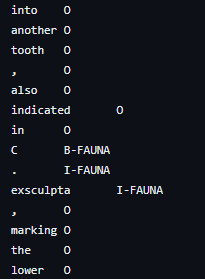

We pre-made this example file for you to run the example code, but if you want to transform your own dataset to the required IOB-format, make sure to check out our Annotations_to_IOB.ipynb Notebook on our [Github](https://github.com/GhentCDH/CLSinfra/tree/main/Notebooks)!

In [ ]:
# 1. define label names in natural language since some datasets come with cryptic set of labels
label_name_map = {"FLORA": "Flora entities such as plants and fruit",
                  "FAUNA": "Fauna entities such as animals"}

In [ ]:
columns = {0: "text", 1: "bio" }

corpus: Corpus = ColumnCorpus("/content/CLSinfra/Example_data_CLS/",
                              columns,
                              train_file = "train_fauna_flora.txt",
                              label_name_map = label_name_map)

2024-04-30 15:43:27,928 Reading data from /content/example_data_CLS
2024-04-30 15:43:27,931 Train: /content/example_data_CLS/train_fauna_flora.txt
2024-04-30 15:43:27,932 Dev: None
2024-04-30 15:43:27,933 Test: None
2024-04-30 15:43:28,083 No test split found. Using 0% (i.e. 43 samples) of the train split as test data
2024-04-30 15:43:28,085 No dev split found. Using 0% (i.e. 38 samples) of the train split as dev data


In [ ]:
# 2. what label do we want to predict?
label_type = 'bio'

# 3. make the label dictionary from the corpus
label_dict = corpus.make_label_dictionary(label_type=label_type, add_unk=False)
print(label_dict)

2024-04-30 15:43:32,990 Computing label dictionary. Progress:


0it [00:00, ?it/s]
346it [00:00, 21646.89it/s]

2024-04-30 15:43:33,023 Dictionary created for label 'bio' with 2 values: Fauna entities such as animals (seen 358 times), Flora entities such as plants and fruit (seen 258 times)
Dictionary with 2 tags: Fauna entities such as animals, Flora entities such as plants and fruit


In [ ]:
# init the TARS sequence tagger
tars_tagger: FewshotClassifier = TARSTagger.load('tars-ner')

2024-04-30 15:45:48,152 SequenceTagger predicts: Dictionary with 5 tags: O, S-entity, B-entity, E-entity, I-entity


In [ ]:
# 6. switch to a new task (TARS can do multiple tasks so you must define one)
tars_tagger.add_and_switch_to_new_task(task_name="ner",
                                label_dictionary=label_dict,
                                label_type=label_type,
                                )

# 7. initialize the text classifier trainer
trainer = ModelTrainer(tars_tagger, corpus)

# 8. start the training
trainer.train(base_path='resources/taggers/trec',  # path to store the model artifacts
              learning_rate=0.02,  # use very small learning rate
              mini_batch_size=16,
              mini_batch_chunk_size=4,  # optionally set this if transformer is too much for your machine
              max_epochs=1,  # terminate after 10 epochs
              )

2024-04-30 15:45:52,993 ----------------------------------------------------------------------------------------------------
2024-04-30 15:45:52,999 Model: "TARSTagger(
  (tars_model): SequenceTagger(
    (embeddings): TransformerWordEmbeddings(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=1024, out_features=1024, bias=True)
                  (key): Linear(in_features=1024, out_features=1024, bias=Tru

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

2024-04-30 15:46:28,535 DEV : loss 0.1813339740037918 - f1-score (micro avg)  0.3455
2024-04-30 15:46:28,540  - 0 epochs without improvement
2024-04-30 15:46:28,544 saving best model


2024-04-30 15:46:43,811 ----------------------------------------------------------------------------------------------------
2024-04-30 15:46:43,820 Loading model from best epoch ...
2024-04-30 15:46:56,185 SequenceTagger predicts: Dictionary with 5 tags: O, S-entity, B-entity, E-entity, I-entity


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

2024-04-30 15:46:59,438 
Results:
- F-score (micro) 0.48
- F-score (macro) 0.4635
- Accuracy 0.32

By class:
                                         precision    recall  f1-score   support

         Fauna entities such as animals     0.6538    0.4250    0.5152        40
Flora entities such as plants and fruit     0.5385    0.3333    0.4118        21

                              micro avg     0.6154    0.3934    0.4800        61
                              macro avg     0.5962    0.3792    0.4635        61
                           weighted avg     0.6141    0.3934    0.4796        61

2024-04-30 15:46:59,440 ----------------------------------------------------------------------------------------------------


{'test_score': 0.48}

Training a model creates a new folder **resources** in your Colab Notebook, and automatically saves the **best model** as **best-model.pt**.

You can then load your **few-shot model** trained using the TarsTagger and apply it to a new dataset.

In [ ]:
model_folder = "/content/resources/taggers/trec"

Few_shot_tagger: TARSTagger = TARSTagger.load(os.path.join(model_folder, "best-model.pt"))

2024-04-30 15:51:55,958 SequenceTagger predicts: Dictionary with 5 tags: O, S-entity, B-entity, E-entity, I-entity


In [ ]:
# make a sentence
sentence = Sentence('I saw a weeping willow while passing down the alleyway. The thorns of the roses reminded me of home, in Alabama.')

# predict aspect tags
Few_shot_tagger.predict(sentence)

In [ ]:
print(sentence)

Sentence[24]: "I saw a weeping willow while passing down the alleyway. The thorns of the roses reminded me of home, in Alabama." → ["weeping willow"/Flora entities such as plants and fruit, "roses"/Flora entities such as plants and fruit]


🦾 We now performed few-shot classification using TARS!

# Fine-tune TARSTagger from scratch (any language)

Apart from using Flair's TarsTagger for few shot learning, we can also train the TARS architecture from scratch. Similarly to Flair's SequenceTagger, we specify the embeddings we want to use from the HuggingFace platform (here: bert-based-uncased), and train our model using an IOB-labelled .txt training file.


---



🧠 If you want to improve your own models, it's important to learn more about **hyperparameter tuning**. Look up more information on learning rates, batch sizes, epochs and embeddings.

In [ ]:
# init the TARS sequence tagger
tars_tagger = TARSTagger(
    'test',
    label_dict,
    label_type='bio',
    embeddings='bert-base-uncased', #This model uses BERT-base-uncased embeddings!
    num_negative_labels_to_sample=1,
    prefix=True,
)

# train the model
trainer = ModelTrainer(tars_tagger, corpus)

trainer.train('resources/taggers/finetuned_tagger_tars',
              learning_rate=0.02,
              mini_batch_size=16,
              mini_batch_chunk_size=1,
              max_epochs=20,
              monitor_test=True,
              embeddings_storage_mode="none",
              )

2024-04-30 15:15:56,042 SequenceTagger predicts: Dictionary with 5 tags: O, S-entity, B-entity, E-entity, I-entity
2024-04-30 15:15:56,051 ----------------------------------------------------------------------------------------------------
2024-04-30 15:15:56,054 Model: "TARSTagger(
  (tars_model): SequenceTagger(
    (embeddings): TransformerWordEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30523, 768)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

2024-04-30 15:16:12,799 DEV : loss 0.08356621861457825 - f1-score (micro avg)  0.125



100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

2024-04-30 15:16:13,355 TEST : loss 0.12854349613189697 - f1-score (micro avg)  0.1163
2024-04-30 15:16:13,359  - 0 epochs without improvement
2024-04-30 15:16:13,362 saving best model


2024-04-30 15:16:14,604 ----------------------------------------------------------------------------------------------------
2024-04-30 15:16:16,557 epoch 2 - iter 2/22 - loss 0.12245019 - time (sec): 1.92 - samples/sec: 1513.38 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:17,992 epoch 2 - iter 4/22 - loss 0.12013779 - time (sec): 3.36 - samples/sec: 1768.68 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:19,411 epoch 2 - iter 6/22 - loss 0.11527988 - time (sec): 4.77 - samples/sec: 1775.72 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:20,800 epoch 2 - iter 8/22 - loss 0.12331015 - time (sec): 6.16 - samples/sec: 1756.09 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:22,213 epoch 2 - iter 10/22 - loss 0.12486437 - time (sec): 7.58 - samples/sec: 1760.96 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:23,610 epoch 2 - iter 12/22 - loss 0.12096797 - time (sec): 8.97 - samples/sec: 1749.64 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:25,068 epoch 2 -

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

2024-04-30 15:16:32,271 DEV : loss 0.07488393038511276 - f1-score (micro avg)  0.0



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

2024-04-30 15:16:32,830 TEST : loss 0.1248769462108612 - f1-score (micro avg)  0.0
2024-04-30 15:16:32,834  - 1 epochs without improvement
2024-04-30 15:16:32,836 ----------------------------------------------------------------------------------------------------


2024-04-30 15:16:34,773 epoch 3 - iter 2/22 - loss 0.11212057 - time (sec): 1.91 - samples/sec: 1231.86 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:36,442 epoch 3 - iter 4/22 - loss 0.11204734 - time (sec): 3.58 - samples/sec: 1282.79 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:37,796 epoch 3 - iter 6/22 - loss 0.11647525 - time (sec): 4.94 - samples/sec: 1379.55 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:39,441 epoch 3 - iter 8/22 - loss 0.11375449 - time (sec): 6.58 - samples/sec: 1423.05 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:41,251 epoch 3 - iter 10/22 - loss 0.11443748 - time (sec): 8.39 - samples/sec: 1446.58 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:42,639 epoch 3 - iter 12/22 - loss 0.11657570 - time (sec): 9.78 - samples/sec: 1514.18 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:44,010 epoch 3 - iter 14/22 - loss 0.12019023 - time (sec): 11.15 - samples/sec: 1550.09 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

2024-04-30 15:16:51,255 DEV : loss 0.07008343189954758 - f1-score (micro avg)  0.0678



100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

2024-04-30 15:16:51,969 TEST : loss 0.11941389739513397 - f1-score (micro avg)  0.0256
2024-04-30 15:16:51,974  - 2 epochs without improvement
2024-04-30 15:16:51,976 ----------------------------------------------------------------------------------------------------


2024-04-30 15:16:53,750 epoch 4 - iter 2/22 - loss 0.11807935 - time (sec): 1.75 - samples/sec: 1421.10 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:55,156 epoch 4 - iter 4/22 - loss 0.10824539 - time (sec): 3.15 - samples/sec: 1616.68 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:56,553 epoch 4 - iter 6/22 - loss 0.12054717 - time (sec): 4.55 - samples/sec: 1630.12 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:58,012 epoch 4 - iter 8/22 - loss 0.10671438 - time (sec): 6.01 - samples/sec: 1733.31 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:16:59,454 epoch 4 - iter 10/22 - loss 0.10394816 - time (sec): 7.45 - samples/sec: 1730.06 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:00,820 epoch 4 - iter 12/22 - loss 0.10728994 - time (sec): 8.82 - samples/sec: 1745.01 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:02,230 epoch 4 - iter 14/22 - loss 0.10685444 - time (sec): 10.23 - samples/sec: 1764.38 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

2024-04-30 15:17:08,907 DEV : loss 0.0714699774980545 - f1-score (micro avg)  0.0678



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

2024-04-30 15:17:09,476 TEST : loss 0.12774866819381714 - f1-score (micro avg)  0.0506
2024-04-30 15:17:09,481  - 3 epochs without improvement
2024-04-30 15:17:09,482 ----------------------------------------------------------------------------------------------------


2024-04-30 15:17:10,920 epoch 5 - iter 2/22 - loss 0.09067551 - time (sec): 1.41 - samples/sec: 1924.42 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:12,346 epoch 5 - iter 4/22 - loss 0.09899512 - time (sec): 2.84 - samples/sec: 1839.06 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:13,736 epoch 5 - iter 6/22 - loss 0.09571014 - time (sec): 4.23 - samples/sec: 1859.63 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:15,133 epoch 5 - iter 8/22 - loss 0.11338006 - time (sec): 5.63 - samples/sec: 1817.45 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:16,996 epoch 5 - iter 10/22 - loss 0.10925674 - time (sec): 7.49 - samples/sec: 1772.78 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:18,568 epoch 5 - iter 12/22 - loss 0.10754130 - time (sec): 9.06 - samples/sec: 1683.52 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:19,969 epoch 5 - iter 14/22 - loss 0.10825283 - time (sec): 10.46 - samples/sec: 1693.19 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

2024-04-30 15:17:26,106 DEV : loss 0.0563696064054966 - f1-score (micro avg)  0.6813



100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

2024-04-30 15:17:26,695 TEST : loss 0.1018555760383606 - f1-score (micro avg)  0.4655
2024-04-30 15:17:26,700  - 0 epochs without improvement
2024-04-30 15:17:26,701 saving best model


2024-04-30 15:17:28,023 ----------------------------------------------------------------------------------------------------
2024-04-30 15:17:30,478 epoch 6 - iter 2/22 - loss 0.07236239 - time (sec): 2.42 - samples/sec: 1136.63 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:31,876 epoch 6 - iter 4/22 - loss 0.07703265 - time (sec): 3.82 - samples/sec: 1331.98 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:33,348 epoch 6 - iter 6/22 - loss 0.08556233 - time (sec): 5.29 - samples/sec: 1496.12 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:34,782 epoch 6 - iter 8/22 - loss 0.08276150 - time (sec): 6.73 - samples/sec: 1548.40 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:36,233 epoch 6 - iter 10/22 - loss 0.07949077 - time (sec): 8.18 - samples/sec: 1567.16 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:37,625 epoch 6 - iter 12/22 - loss 0.08193802 - time (sec): 9.57 - samples/sec: 1540.62 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:39,045 epoch 6 -

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

2024-04-30 15:17:45,853 DEV : loss 0.04206002131104469 - f1-score (micro avg)  0.6869



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

2024-04-30 15:17:46,458 TEST : loss 0.08533115684986115 - f1-score (micro avg)  0.4603
2024-04-30 15:17:46,463  - 0 epochs without improvement
2024-04-30 15:17:46,465 saving best model


2024-04-30 15:17:47,694 ----------------------------------------------------------------------------------------------------
2024-04-30 15:17:49,144 epoch 7 - iter 2/22 - loss 0.06237772 - time (sec): 1.42 - samples/sec: 1683.40 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:50,666 epoch 7 - iter 4/22 - loss 0.06302085 - time (sec): 2.94 - samples/sec: 1795.35 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:52,069 epoch 7 - iter 6/22 - loss 0.07071268 - time (sec): 4.35 - samples/sec: 1761.74 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:53,943 epoch 7 - iter 8/22 - loss 0.07022185 - time (sec): 6.22 - samples/sec: 1614.04 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:55,488 epoch 7 - iter 10/22 - loss 0.07528038 - time (sec): 7.77 - samples/sec: 1584.94 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:56,991 epoch 7 - iter 12/22 - loss 0.07902398 - time (sec): 9.27 - samples/sec: 1644.91 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:17:58,386 epoch 7 -

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

2024-04-30 15:18:04,716 DEV : loss 0.039396584033966064 - f1-score (micro avg)  0.6957



100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

2024-04-30 15:18:05,450 TEST : loss 0.08968411386013031 - f1-score (micro avg)  0.5479
2024-04-30 15:18:05,455  - 0 epochs without improvement
2024-04-30 15:18:05,457 saving best model


2024-04-30 15:18:07,159 ----------------------------------------------------------------------------------------------------
2024-04-30 15:18:08,674 epoch 8 - iter 2/22 - loss 0.05550201 - time (sec): 1.49 - samples/sec: 1677.97 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:10,061 epoch 8 - iter 4/22 - loss 0.06281980 - time (sec): 2.87 - samples/sec: 1654.99 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:11,470 epoch 8 - iter 6/22 - loss 0.06355809 - time (sec): 4.28 - samples/sec: 1673.41 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:12,861 epoch 8 - iter 8/22 - loss 0.06769192 - time (sec): 5.67 - samples/sec: 1677.85 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:14,267 epoch 8 - iter 10/22 - loss 0.06518237 - time (sec): 7.08 - samples/sec: 1721.38 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:15,655 epoch 8 - iter 12/22 - loss 0.06793671 - time (sec): 8.47 - samples/sec: 1714.88 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:17,088 epoch 8 -

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

2024-04-30 15:18:23,977 DEV : loss 0.038656435906887054 - f1-score (micro avg)  0.7257



100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

2024-04-30 15:18:24,561 TEST : loss 0.07938855141401291 - f1-score (micro avg)  0.5694
2024-04-30 15:18:24,565  - 0 epochs without improvement
2024-04-30 15:18:24,568 saving best model


2024-04-30 15:18:25,795 ----------------------------------------------------------------------------------------------------
2024-04-30 15:18:27,239 epoch 9 - iter 2/22 - loss 0.06327053 - time (sec): 1.42 - samples/sec: 1954.74 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:28,683 epoch 9 - iter 4/22 - loss 0.06028820 - time (sec): 2.86 - samples/sec: 1955.12 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:30,378 epoch 9 - iter 6/22 - loss 0.06155672 - time (sec): 4.56 - samples/sec: 1672.23 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:32,175 epoch 9 - iter 8/22 - loss 0.06350584 - time (sec): 6.35 - samples/sec: 1549.17 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:33,626 epoch 9 - iter 10/22 - loss 0.06430654 - time (sec): 7.80 - samples/sec: 1580.68 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:35,033 epoch 9 - iter 12/22 - loss 0.06402811 - time (sec): 9.21 - samples/sec: 1597.17 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:36,458 epoch 9 -

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

2024-04-30 15:18:43,005 DEV : loss 0.03632335364818573 - f1-score (micro avg)  0.752



100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

2024-04-30 15:18:44,494 TEST : loss 0.07844817638397217 - f1-score (micro avg)  0.589
2024-04-30 15:18:44,501  - 0 epochs without improvement
2024-04-30 15:18:44,513 saving best model


2024-04-30 15:18:46,494 ----------------------------------------------------------------------------------------------------
2024-04-30 15:18:47,975 epoch 10 - iter 2/22 - loss 0.06734749 - time (sec): 1.45 - samples/sec: 1745.65 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:49,336 epoch 10 - iter 4/22 - loss 0.06071120 - time (sec): 2.81 - samples/sec: 1625.80 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:50,761 epoch 10 - iter 6/22 - loss 0.05161985 - time (sec): 4.24 - samples/sec: 1678.00 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:52,249 epoch 10 - iter 8/22 - loss 0.05310953 - time (sec): 5.72 - samples/sec: 1689.01 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:53,658 epoch 10 - iter 10/22 - loss 0.05328034 - time (sec): 7.13 - samples/sec: 1679.70 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:55,423 epoch 10 - iter 12/22 - loss 0.05226299 - time (sec): 8.90 - samples/sec: 1585.23 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:18:57,169 epo

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

2024-04-30 15:19:04,342 DEV : loss 0.03583361953496933 - f1-score (micro avg)  0.7642



100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

2024-04-30 15:19:05,060 TEST : loss 0.07503195106983185 - f1-score (micro avg)  0.5802
2024-04-30 15:19:05,064  - 0 epochs without improvement
2024-04-30 15:19:05,067 saving best model


2024-04-30 15:19:06,713 ----------------------------------------------------------------------------------------------------
2024-04-30 15:19:08,856 epoch 11 - iter 2/22 - loss 0.04982941 - time (sec): 2.10 - samples/sec: 1248.98 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:10,284 epoch 11 - iter 4/22 - loss 0.04220824 - time (sec): 3.53 - samples/sec: 1414.67 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:11,898 epoch 11 - iter 6/22 - loss 0.04632678 - time (sec): 5.15 - samples/sec: 1427.25 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:13,833 epoch 11 - iter 8/22 - loss 0.04863276 - time (sec): 7.08 - samples/sec: 1414.04 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:15,262 epoch 11 - iter 10/22 - loss 0.04979206 - time (sec): 8.51 - samples/sec: 1433.12 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:16,650 epoch 11 - iter 12/22 - loss 0.04938217 - time (sec): 9.90 - samples/sec: 1491.54 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:18,134 epo

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

2024-04-30 15:19:24,989 DEV : loss 0.03390524908900261 - f1-score (micro avg)  0.8136



100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

2024-04-30 15:19:25,601 TEST : loss 0.08436500281095505 - f1-score (micro avg)  0.6065
2024-04-30 15:19:25,605  - 0 epochs without improvement
2024-04-30 15:19:25,607 saving best model


2024-04-30 15:19:27,471 ----------------------------------------------------------------------------------------------------
2024-04-30 15:19:28,997 epoch 12 - iter 2/22 - loss 0.03105485 - time (sec): 1.49 - samples/sec: 1637.14 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:30,542 epoch 12 - iter 4/22 - loss 0.04460894 - time (sec): 3.04 - samples/sec: 1879.52 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:32,355 epoch 12 - iter 6/22 - loss 0.04301711 - time (sec): 4.85 - samples/sec: 1708.77 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:34,087 epoch 12 - iter 8/22 - loss 0.04801366 - time (sec): 6.58 - samples/sec: 1578.88 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:35,478 epoch 12 - iter 10/22 - loss 0.04556491 - time (sec): 7.97 - samples/sec: 1622.50 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:36,895 epoch 12 - iter 12/22 - loss 0.04290967 - time (sec): 9.39 - samples/sec: 1629.98 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:38,297 epo

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

2024-04-30 15:19:44,844 DEV : loss 0.034942626953125 - f1-score (micro avg)  0.7581



100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

2024-04-30 15:19:45,590 TEST : loss 0.07258044183254242 - f1-score (micro avg)  0.6582
2024-04-30 15:19:45,594  - 1 epochs without improvement
2024-04-30 15:19:45,596 ----------------------------------------------------------------------------------------------------


2024-04-30 15:19:47,012 epoch 13 - iter 2/22 - loss 0.04383085 - time (sec): 1.39 - samples/sec: 1723.97 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:48,428 epoch 13 - iter 4/22 - loss 0.04802752 - time (sec): 2.81 - samples/sec: 1674.41 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:50,332 epoch 13 - iter 6/22 - loss 0.04358012 - time (sec): 4.71 - samples/sec: 1620.63 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:51,755 epoch 13 - iter 8/22 - loss 0.03790330 - time (sec): 6.14 - samples/sec: 1690.56 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:53,168 epoch 13 - iter 10/22 - loss 0.04140249 - time (sec): 7.55 - samples/sec: 1609.39 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:54,580 epoch 13 - iter 12/22 - loss 0.04139386 - time (sec): 8.96 - samples/sec: 1647.79 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:19:56,143 epoch 13 - iter 14/22 - loss 0.03846585 - time (sec): 10.52 - samples/sec: 1643.42 - lr: 0.020000 - momentum: 0.000000
2024-04-3

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

2024-04-30 15:20:02,897 DEV : loss 0.04679938778281212 - f1-score (micro avg)  0.781



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

2024-04-30 15:20:03,504 TEST : loss 0.09025238454341888 - f1-score (micro avg)  0.6573
2024-04-30 15:20:03,508  - 2 epochs without improvement
2024-04-30 15:20:03,510 ----------------------------------------------------------------------------------------------------


2024-04-30 15:20:04,939 epoch 14 - iter 2/22 - loss 0.03871673 - time (sec): 1.40 - samples/sec: 1367.81 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:06,359 epoch 14 - iter 4/22 - loss 0.04773336 - time (sec): 2.82 - samples/sec: 1462.48 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:07,895 epoch 14 - iter 6/22 - loss 0.04101925 - time (sec): 4.36 - samples/sec: 1662.53 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:09,822 epoch 14 - iter 8/22 - loss 0.03880448 - time (sec): 6.29 - samples/sec: 1508.93 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:11,280 epoch 14 - iter 10/22 - loss 0.03903773 - time (sec): 7.75 - samples/sec: 1529.69 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:12,697 epoch 14 - iter 12/22 - loss 0.03874954 - time (sec): 9.16 - samples/sec: 1570.18 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:14,161 epoch 14 - iter 14/22 - loss 0.03698702 - time (sec): 10.63 - samples/sec: 1630.36 - lr: 0.020000 - momentum: 0.000000
2024-04-3

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

2024-04-30 15:20:20,548 DEV : loss 0.03430047631263733 - f1-score (micro avg)  0.7833



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

2024-04-30 15:20:21,318 TEST : loss 0.0696592852473259 - f1-score (micro avg)  0.7037
2024-04-30 15:20:21,324  - 3 epochs without improvement
2024-04-30 15:20:21,327 ----------------------------------------------------------------------------------------------------


2024-04-30 15:20:23,082 epoch 15 - iter 2/22 - loss 0.05330794 - time (sec): 1.72 - samples/sec: 1305.74 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:24,510 epoch 15 - iter 4/22 - loss 0.04182059 - time (sec): 3.15 - samples/sec: 1416.60 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:25,890 epoch 15 - iter 6/22 - loss 0.03712754 - time (sec): 4.53 - samples/sec: 1505.42 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:27,305 epoch 15 - iter 8/22 - loss 0.03589456 - time (sec): 5.95 - samples/sec: 1564.68 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:28,806 epoch 15 - iter 10/22 - loss 0.03290476 - time (sec): 7.45 - samples/sec: 1663.94 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:30,221 epoch 15 - iter 12/22 - loss 0.03369831 - time (sec): 8.86 - samples/sec: 1687.78 - lr: 0.020000 - momentum: 0.000000
2024-04-30 15:20:31,686 epoch 15 - iter 14/22 - loss 0.03426529 - time (sec): 10.33 - samples/sec: 1681.45 - lr: 0.020000 - momentum: 0.000000
2024-04-3

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

2024-04-30 15:20:38,613 DEV : loss 0.03496831655502319 - f1-score (micro avg)  0.768



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

2024-04-30 15:20:39,232 TEST : loss 0.07822634279727936 - f1-score (micro avg)  0.6627
2024-04-30 15:20:39,236  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.01]
2024-04-30 15:20:39,239 ----------------------------------------------------------------------------------------------------


2024-04-30 15:20:40,701 epoch 16 - iter 2/22 - loss 0.01770465 - time (sec): 1.44 - samples/sec: 1910.00 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:20:42,160 epoch 16 - iter 4/22 - loss 0.01716425 - time (sec): 2.90 - samples/sec: 1924.01 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:20:43,513 epoch 16 - iter 6/22 - loss 0.01901784 - time (sec): 4.25 - samples/sec: 1811.54 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:20:45,037 epoch 16 - iter 8/22 - loss 0.01900683 - time (sec): 5.77 - samples/sec: 1704.53 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:20:46,943 epoch 16 - iter 10/22 - loss 0.01935133 - time (sec): 7.68 - samples/sec: 1641.70 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:20:48,341 epoch 16 - iter 12/22 - loss 0.02043871 - time (sec): 9.08 - samples/sec: 1627.80 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:20:49,716 epoch 16 - iter 14/22 - loss 0.02090406 - time (sec): 10.45 - samples/sec: 1612.93 - lr: 0.010000 - momentum: 0.000000
2024-04-3

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

2024-04-30 15:20:56,545 DEV : loss 0.03938146308064461 - f1-score (micro avg)  0.7934



100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

2024-04-30 15:20:57,272 TEST : loss 0.0863179862499237 - f1-score (micro avg)  0.6875
2024-04-30 15:20:57,279  - 1 epochs without improvement
2024-04-30 15:20:57,287 ----------------------------------------------------------------------------------------------------


2024-04-30 15:20:59,232 epoch 17 - iter 2/22 - loss 0.02382648 - time (sec): 1.91 - samples/sec: 1385.48 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:00,669 epoch 17 - iter 4/22 - loss 0.02268168 - time (sec): 3.34 - samples/sec: 1497.78 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:02,104 epoch 17 - iter 6/22 - loss 0.02132351 - time (sec): 4.78 - samples/sec: 1557.53 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:03,557 epoch 17 - iter 8/22 - loss 0.02261301 - time (sec): 6.23 - samples/sec: 1607.55 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:04,971 epoch 17 - iter 10/22 - loss 0.02162774 - time (sec): 7.64 - samples/sec: 1600.75 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:06,460 epoch 17 - iter 12/22 - loss 0.01948957 - time (sec): 9.13 - samples/sec: 1650.04 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:07,879 epoch 17 - iter 14/22 - loss 0.02078258 - time (sec): 10.55 - samples/sec: 1664.35 - lr: 0.010000 - momentum: 0.000000
2024-04-3

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

2024-04-30 15:21:14,778 DEV : loss 0.03625927120447159 - f1-score (micro avg)  0.8067



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

2024-04-30 15:21:15,395 TEST : loss 0.08996113389730453 - f1-score (micro avg)  0.7484
2024-04-30 15:21:15,399  - 2 epochs without improvement
2024-04-30 15:21:15,402 ----------------------------------------------------------------------------------------------------


2024-04-30 15:21:16,838 epoch 18 - iter 2/22 - loss 0.02471210 - time (sec): 1.41 - samples/sec: 1803.33 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:18,249 epoch 18 - iter 4/22 - loss 0.02085567 - time (sec): 2.82 - samples/sec: 1737.60 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:19,653 epoch 18 - iter 6/22 - loss 0.01926839 - time (sec): 4.23 - samples/sec: 1752.74 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:21,104 epoch 18 - iter 8/22 - loss 0.01852301 - time (sec): 5.68 - samples/sec: 1730.86 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:23,033 epoch 18 - iter 10/22 - loss 0.01738806 - time (sec): 7.61 - samples/sec: 1634.29 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:24,610 epoch 18 - iter 12/22 - loss 0.01742506 - time (sec): 9.19 - samples/sec: 1630.72 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:26,193 epoch 18 - iter 14/22 - loss 0.01820401 - time (sec): 10.77 - samples/sec: 1701.60 - lr: 0.010000 - momentum: 0.000000
2024-04-3

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

2024-04-30 15:21:32,485 DEV : loss 0.03365568071603775 - f1-score (micro avg)  0.8421



100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

2024-04-30 15:21:33,100 TEST : loss 0.091208316385746 - f1-score (micro avg)  0.7383
2024-04-30 15:21:33,104  - 0 epochs without improvement
2024-04-30 15:21:33,107 saving best model


2024-04-30 15:21:34,796 ----------------------------------------------------------------------------------------------------
2024-04-30 15:21:36,670 epoch 19 - iter 2/22 - loss 0.01584520 - time (sec): 1.82 - samples/sec: 1253.15 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:38,099 epoch 19 - iter 4/22 - loss 0.01826534 - time (sec): 3.25 - samples/sec: 1460.80 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:39,525 epoch 19 - iter 6/22 - loss 0.01848662 - time (sec): 4.68 - samples/sec: 1499.48 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:41,001 epoch 19 - iter 8/22 - loss 0.01793715 - time (sec): 6.15 - samples/sec: 1588.38 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:42,447 epoch 19 - iter 10/22 - loss 0.01768120 - time (sec): 7.60 - samples/sec: 1600.39 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:43,843 epoch 19 - iter 12/22 - loss 0.01703544 - time (sec): 8.99 - samples/sec: 1596.91 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:45,304 epo

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

2024-04-30 15:21:52,270 DEV : loss 0.03751208633184433 - f1-score (micro avg)  0.8103



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

2024-04-30 15:21:53,334 TEST : loss 0.085504449903965 - f1-score (micro avg)  0.7436
2024-04-30 15:21:53,338  - 1 epochs without improvement
2024-04-30 15:21:53,340 ----------------------------------------------------------------------------------------------------


2024-04-30 15:21:54,790 epoch 20 - iter 2/22 - loss 0.01781341 - time (sec): 1.42 - samples/sec: 1805.14 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:56,233 epoch 20 - iter 4/22 - loss 0.02230762 - time (sec): 2.87 - samples/sec: 1684.80 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:57,620 epoch 20 - iter 6/22 - loss 0.02274046 - time (sec): 4.25 - samples/sec: 1607.45 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:21:59,316 epoch 20 - iter 8/22 - loss 0.02190306 - time (sec): 5.95 - samples/sec: 1516.67 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:22:01,135 epoch 20 - iter 10/22 - loss 0.01954144 - time (sec): 7.77 - samples/sec: 1495.92 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:22:02,539 epoch 20 - iter 12/22 - loss 0.01760502 - time (sec): 9.17 - samples/sec: 1547.57 - lr: 0.010000 - momentum: 0.000000
2024-04-30 15:22:04,031 epoch 20 - iter 14/22 - loss 0.01618811 - time (sec): 10.66 - samples/sec: 1614.36 - lr: 0.010000 - momentum: 0.000000
2024-04-3

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

2024-04-30 15:22:10,304 DEV : loss 0.0378284826874733 - f1-score (micro avg)  0.8205



100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

2024-04-30 15:22:11,021 TEST : loss 0.0989798754453659 - f1-score (micro avg)  0.7662
2024-04-30 15:22:11,027  - 2 epochs without improvement


2024-04-30 15:22:12,658 ----------------------------------------------------------------------------------------------------
2024-04-30 15:22:12,662 Loading model from best epoch ...
2024-04-30 15:22:14,967 SequenceTagger predicts: Dictionary with 5 tags: O, S-entity, B-entity, E-entity, I-entity


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

2024-04-30 15:22:15,786 
Results:
- F-score (micro) 0.7383
- F-score (macro) 0.7429
- Accuracy 0.5851

By class:
              precision    recall  f1-score   support

       FAUNA     0.7111    0.7273    0.7191        44
       FLORA     0.8214    0.7188    0.7667        32

   micro avg     0.7534    0.7237    0.7383        76
   macro avg     0.7663    0.7230    0.7429        76
weighted avg     0.7576    0.7237    0.7391        76

2024-04-30 15:22:15,789 ----------------------------------------------------------------------------------------------------


{'test_score': 0.738255033557047}

**With only 76 labelled sentences, we managed to fine-tune TARS**! Our final F1 score is a micro average of 0.74, which is pretty impressive for a dataset as small as ours!

Our best model is saved in a new folder (/resources/taggers/few-shot-sequence-tagger). To load it and apply it to our dataset, we can simply run the code below.




---

❗💪🏼 Remember: modelling is experimenting. Flair makes it pretty easy to start modelling and model testing, but the results can always be improved through **hyperparameter tuning, adding more data** or **changing the embeddings you used**. Compare the results when training the model with these tweaked parameters. Remember that **in order to compare the model, you also have to train and test it on the same splits of your dataset for train and test respectively.**

In [ ]:
model_folder = "'resources/taggers/finetuned_tagger_tars"

tagger: TARSTagger = TARSTagger.load(os.path.join(model_folder, "best-model.pt"))

2024-04-30 15:31:25,073 SequenceTagger predicts: Dictionary with 5 tags: O, S-entity, B-entity, E-entity, I-entity


In [ ]:
# make a sentence
sentence = Sentence('I saw a weeping willow while passing down the alleyway. The thorns of the roses reminded me of home, in Alabama.')

# predict aspect tags
tagger.predict(sentence)

In [ ]:
print(sentence)

Sentence[24]: "I saw a weeping willow while passing down the alleyway. The thorns of the roses reminded me of home, in Alabama." → ["weeping willow"/FLORA, "the"/FLORA, "roses"/FLORA]


# Output of fine-tuned model to CSV

This sections shows you how to apply off-the-shelf or custom taggers to your corpus, and save the result as a .csv- file in the following format.

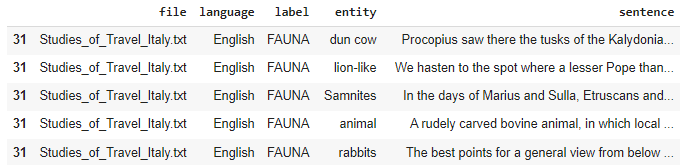

In [ ]:
# Let's use a partition of our corpus to showcase the approach.
English_corpus_sample = English_corpus[1:2]

In [ ]:
def ner_custom(text, tagger = tagger):
  sentences = splitter.split(text) # We split the text into sentences to feed to the model.

  #predict tags with custom tagger
  tagger.predict(sentences)

  output = []
  for sentence in sentences:
    for entity in sentence.get_spans():
      ent_label = entity.tag
      ent_text = entity.text

      output.append((ent_label, ent_text, sentence.text))
  return output

In [ ]:
ner_custom("I saw a weeping willow while passing down the alleyway. The thorns of the roses reminded me of home, in Alabama.", tagger = tagger)

[('FLORA',
  'weeping willow',
  'I saw a weeping willow while passing down the alleyway.'),
 ('FLORA', 'of', 'The thorns of the roses reminded me of home, in Alabama.'),
 ('FLORA', 'the', 'The thorns of the roses reminded me of home, in Alabama.'),
 ('FLORA',
  'roses',
  'The thorns of the roses reminded me of home, in Alabama.')]

In [ ]:
# let's apply our custom tagger to a sample of our corpus!

English_corpus_sample['results'] = English_corpus_sample.text.progress_apply(ner_custom)

  0%|          | 0/1 [00:00<?, ?it/s]

2024-04-30 16:10:00,922 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2024-04-30 16:10:13,298 Ignore 1 sentence(s) with no tokens.


<ipython-input-64-1cd00a8c287c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  English_corpus_sample['results'] = English_corpus_sample.text.progress_apply(ner_custom)


In [ ]:
English_corpus_sample = English_corpus_sample.explode("results")

English_corpus_sample['label'], English_corpus_sample['entity'], English_corpus_sample["sentence"] = zip(*English_corpus_sample.results)

In [ ]:
English_corpus_sample.drop(["results", "text"], inplace = True, axis = 1)

In [ ]:
English_corpus_sample.sample(10)

file language  label     entity  \
31  Studies_of_Travel_Italy.txt  English  FAUNA    dun cow   
31  Studies_of_Travel_Italy.txt  English  FAUNA  lion-like   
31  Studies_of_Travel_Italy.txt  English  FAUNA   Samnites   
31  Studies_of_Travel_Italy.txt  English  FAUNA     animal   
31  Studies_of_Travel_Italy.txt  English  FAUNA    rabbits   
31  Studies_of_Travel_Italy.txt  English  FAUNA        rex   
31  Studies_of_Travel_Italy.txt  English  FAUNA    Serapis   
31  Studies_of_Travel_Italy.txt  English  FLORA       nuts   
31  Studies_of_Travel_Italy.txt  English  FAUNA   monsters   
31  Studies_of_Travel_Italy.txt  English  FAUNA  elephants   

                                             sentence  
31  Procopius saw there the tusks of the Kalydonia...  
31  We hasten to the spot where a lesser Pope than...  
31  In the days of Marius and Sulla, Etruscans and...  
31  A rudely carved bovine animal, in which local ...  
31  The best points for a general view from below ...  
31  But, after all, the "still glassy lake" to whi...  
31  But here we see them within walls reared in ho...  
31  Among other things he ordained that thirty bus...  
31  An elaborate round-headed opening is covered w...  
31  This last has much to show in many ways; most ...

# More information

## Flair

Apart from a TarsTagger, we can also train one of Flair's **SequenceTaggers**. This is a different type of tagger architecture made by Flair. If you're interested to see how to train this, check out **our ABSA-workflows** on our [GitHub](https://github.com/GhentCDH/CLSinfra/tree/main), where we use the output of our custom trained SequenceTagger to perform **aspect-based sentiment analysis** for French, English, German and Dutch!


## Embeddings

Flair uses HuggingFace embeddings to transform your corpus for training. There are historical embeddings available for historical **English (1450-1950)** and historical **Dutch (1500-1950)** which may improve your results! Definitely check out the work on MacBerth and GysBert, and experiment with this setting!


## Sources

Manjavacas, Enrique & Lauren Fonteyn. 2022. Adapting vs. Pre-training Language Models for Historical Languages. Journal of Data Mining & Digital Humanities jdmdh:9152. https://doi.org/10.46298/jdmdh.9152

Manjavacas, Enrique & Lauren Fonteyn. 2022. Non-Parametric Word Sense Disambiguation for Historical Languages. Proceedings of the 2nd International Workshop on Natural Language Processing for Digital Humanities (NLP4DH), 123-134. Association for Computational Linguistics. https://aclanthology.org/2022.nlp4dh-1.16